In [1]:
import cairo
from io import BytesIO
import IPython.display

In [2]:
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict

In [4]:
#https://pypi.org/project/hilbertcurve/
#!pip install hilbertcurve

In [5]:
from hilbertcurve.hilbertcurve import HilbertCurve

In [6]:
hilbert_curve = HilbertCurve(p=5, n=2)
print(hilbert_curve.max_x, hilbert_curve.max_h)

31 1023


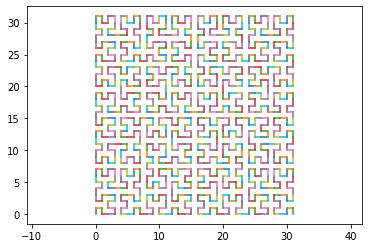

In [7]:
for k in range(hilbert_curve.max_h):
    ij0 = hilbert_curve.coordinates_from_distance(k)
    ij1 = hilbert_curve.coordinates_from_distance(k+1)
    plt.plot([ij0[0], ij1[0]], [ij0[1], ij1[1]])
plt.axis('equal');

In [8]:
voisins = [(+1, 0),
           (-1, 0),
           (0, +1), 
           (0, -1)]

def topple(z):
    a = np.copy(z)
    k = 0
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):

            if z[i, j] > 5:
                k += 1
                a[i, j] -= 4

                for vh, vv in voisins:
                    try:
                        a[i+vv, j+vh] += 1
                    except IndexError:
                        pass
    return a, k

def stabilize(z):
    
    for nbr_iter in range(10000):
        z, k = topple(z)
        if k == 0:
            break
    else:
        print('not stable yet')
    
    return z, nbr_iter

776


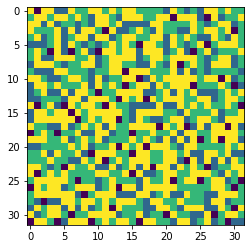

In [9]:
n = hilbert_curve.max_x + 1
z0 = np.random.randint(5, 16, (n, n))
z0, nbr_iter = stabilize(z0)
plt.imshow(z0);
print(nbr_iter)

start at (10, 20) of length 96


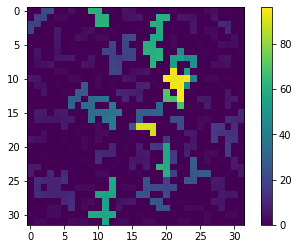

In [10]:
# k map - avalanche size for each starting cell
kmap = np.zeros_like(z0)
for i in range(z0.shape[0]):
    for j in range(z0.shape[1]):
        a = np.copy(z0)
        a[i, j] += 1
        a1, nbr_iter = stabilize(a)
        kmap[i, j] = nbr_iter

plt.imshow(kmap); plt.colorbar();

ij_max = np.unravel_index(np.argmax(kmap), kmap.shape)
print('start at', ij_max, 'of length', kmap[ij_max])

In [11]:
z = np.copy(z0)
z[ij_max] += 1

topple_events = []
acc_events = defaultdict(list)

for nbr_iter in range(100):
    a = np.copy(z)
    k = 0
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):

            if z[i, j] > 5:
                #print(nbr_iter, (i, j))
                k += 1
                a[i, j] -= 4
                topple_events.append((nbr_iter, i, j))
                for vh, vv in voisins:
                    if i+vv < 0 or i+vv >= a.shape[0]:
                        continue
                    if j+vh < 0 or j+vh >= a.shape[1]:
                        continue    
                    
                    a[i+vv, j+vh] += 1
                    acc_events[(i+vv, j+vh)].append((nbr_iter, i, j))

    if k == 0:
        break
    z = np.copy(a)

In [12]:
# Remove empty columns
active_cells_coords = list(acc_events.keys())
active_cells_coords = [(*c, ) for t, *c in topple_events]

active_cells_coords_hidx = [hilbert_curve.distance_from_coordinates(coords)
                            for coords in active_cells_coords]


col_idx_sort = {active_cells_coords[idx]:c for c, idx in enumerate(np.argsort(active_cells_coords_hidx))}

def get_col_index(coords):
    return col_idx_sort[(*coords, )]

In [13]:
col_spacing = 2
line_spacing = 5

nbr_col = len(active_cells_coords)
nbr_lines = kmap[ij_max] + 1

margin = 10
width = 2*margin + (nbr_col - 1)*col_spacing
height = 2*margin + (nbr_lines - 1)*line_spacing

dot_radius = 1

print(width, height)

1344 500


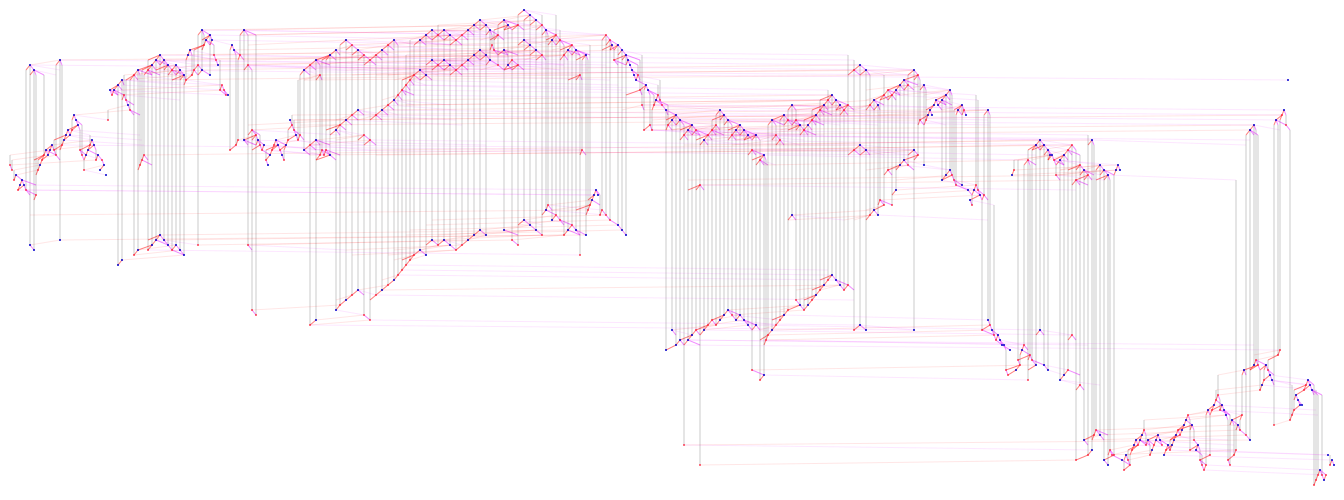

In [14]:
# https://nedbatchelder.com/blog/201901/drawing_cairo_svg_in_a_jupyter_notebook.html
svgio = BytesIO()
with cairo.SVGSurface(svgio, width, height) as surface:
    context = cairo.Context(surface)

    for coords, previous in acc_events.items():
               
        if coords not in active_cells_coords:
            continue
        col_idx = get_col_index(coords)
        x_cell = margin + col_idx*col_spacing
        
        #context.set_source_rgba(1, 0.2, 0.2, 0.8)
        #context.arc(x_src, y_src, dot_radius, 0, 2*np.pi)
        #context.fill()
        previous_y = None
        for time, *src_coords in previous:
            
            # have topled after ?
            futur = [(t, c) for t, *c in topple_events
                     if (*coords, ) == (*c, ) and time < t]
            if len(futur)==0:
                continue
        
            col_idx_src = get_col_index(src_coords)
            x_src = margin + col_idx_src*col_spacing
            y_src = margin + time*line_spacing
            y_tgt = margin + (time + 1)*line_spacing
            
            # acc line
            if np.abs(x_cell - x_src) < 8*col_spacing:
                alpha = 0.5    
            else:
                alpha = 0.1
            
            if x_cell - x_src < 0:
                color =  (1, 0, 0)
            else:
                color = (.9, .1, 8)

            context.set_source_rgba(*color, alpha)
            
            context.move_to(x_src, y_src)
            context.line_to(x_cell, y_tgt)
            
            context.set_line_width(1)
            context.stroke()
            
            # vertical line
            if previous_y:
                context.move_to(x_cell, y_tgt)
                context.line_to(x_cell, previous_y)
                context.set_source_rgba(0, 0, 0, 0.2)
                context.set_line_width(1)
                context.stroke()  
            
            previous_y = y_tgt

            
    # topple - dot
    for time, *coords in topple_events:
        col_idx = get_col_index(coords)
        x_src = margin + col_idx*col_spacing
        y_src = margin + time*line_spacing
        
        # dot
        if z0[tuple(coords)] == 5:
            context.set_source_rgba(0., 0.0, 0.8, 1.0)
        else:
            context.set_source_rgba(1., 0.1, 0.2, 0.8)
        context.arc(x_src, y_src, dot_radius, 0, 2*np.pi)
        context.fill()
        
IPython.display.SVG(data=svgio.getvalue())

    
    question : est-ce qu'il y a des sous-avalanches indépendantes ? cad declanchée par 1 seul évenement
    
        have to be a pre-unstable cell (pristine height == 4)
        --> assign a color, draw sub-avalanche with this color -> no, not only one
        
        
    draw hilbert neigbours, arch